### Bibliotecas

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline

from sklearn import metrics
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay, roc_curve
from scipy import stats

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import joblib

import warnings
warnings.filterwarnings('ignore')

### Dataset Cadastros

In [2]:
# carregando a base de cadastro
cadastros = pd.read_csv(r'https://github.com/alura-tech/alura-tech-pos-data-science-credit-scoring-streamlit/blob/main/dados/clientes_cadastrados.csv?raw=True')

In [3]:
cadastros.head(3)

,ID_Cliente,Genero,Tem_carro,Tem_casa_propria,Qtd_filhos,Rendimento_anual,Categoria_de_renda,Grau_escolaridade,Estado_civil,Moradia,Idade,Anos_empregado,Tem_celular,Tem_telefone_trabalho,Tem_telefone_fixo,Tem_email,Ocupacao,Tamanho_familia
0,5008804,M,Y,Y,0,427500.0,Empregado,Ensino superior,União-estável,Apartamento alugado,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Empregado,Ensino superior,União-estável,Apartamento alugado,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Empregado,Ensino médio,Casado,Casa/apartamento próprio,-21474,-1134,1,0,0,0,Segurança,2.0


In [4]:
# tamanho do df
cadastros.shape

(438557, 18)

#### Tratamento

In [5]:
# excluindo duplicados
id_rep = cadastros[cadastros['ID_Cliente'].duplicated(keep=False)]
df_cadastro = cadastros.drop(id_rep.index)

In [6]:
# verificando dados nulos
df_cadastro.isnull().sum()

ID_Cliente                    0
Genero                        0
Tem_carro                     0
Tem_casa_propria              0
Qtd_filhos                    0
Rendimento_anual              0
Categoria_de_renda            0
Grau_escolaridade             0
Estado_civil                  0
Moradia                       0
Idade                         0
Anos_empregado                0
Tem_celular                   0
Tem_telefone_trabalho         0
Tem_telefone_fixo             0
Tem_email                     0
Ocupacao                 134177
Tamanho_familia               0
dtype: int64

In [7]:
# verificando os dados na coluna que tem valores vazios
df_cadastro['Ocupacao'].unique()

array([nan, 'Segurança', 'Vendas', 'Contabilidade', 'Construção Civil',
       'Gerência', 'Motorista', 'Equipe principal', 'Alta tecnologia',
       'Limpeza', 'Serviço privado', 'Cozinha', 'Baixa qualificação',
       'Medicina', 'Secretariado', 'Garçom', 'RH', 'Corretor imobiliário',
       'TI'], dtype=object)

In [8]:
# substituindo os vazios por 'outros'
df_cadastro['Ocupacao'].fillna(value='Outros', inplace=True)

In [9]:
# verificando quantidade de valores distintos por coluna
df_cadastro.nunique()

ID_Cliente               438463
Genero                        2
Tem_carro                     2
Tem_casa_propria              2
Qtd_filhos                   12
Rendimento_anual            866
Categoria_de_renda            5
Grau_escolaridade             5
Estado_civil                  5
Moradia                       6
Idade                     16379
Anos_empregado             9406
Tem_celular                   1
Tem_telefone_trabalho         2
Tem_telefone_fixo             2
Tem_email                     2
Ocupacao                     19
Tamanho_familia              13
dtype: int64

In [10]:
# tratamento de colunas
df_cadastro = df_cadastro.assign(
                                Tem_carro = np.where(df_cadastro['Tem_carro'] == 'Y', 1, 0),
                                Tem_casa_propria = np.where(df_cadastro['Tem_casa_propria'] == 'Y', 1, 0),
                                Idade = - (df_cadastro['Idade']/365.2425),
                                Anos_empregado=lambda x: np.where(-(x['Anos_empregado'] / 365.2425) < 0,
                                                                  0, 
                                                                  -(x['Anos_empregado'] / 365.2425))
                                                                  )

In [11]:
# removendo colunas
df_cadastro.drop(columns=['Genero', 'Tem_celular'], inplace=True)

In [12]:
# verificando tipo de dados
df_cadastro.info()

<class 'pandas.core.frame.DataFrame'>
Index: 438463 entries, 0 to 438556
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID_Cliente             438463 non-null  int64  
 1   Tem_carro              438463 non-null  int32  
 2   Tem_casa_propria       438463 non-null  int32  
 3   Qtd_filhos             438463 non-null  int64  
 4   Rendimento_anual       438463 non-null  float64
 5   Categoria_de_renda     438463 non-null  object 
 6   Grau_escolaridade      438463 non-null  object 
 7   Estado_civil           438463 non-null  object 
 8   Moradia                438463 non-null  object 
 9   Idade                  438463 non-null  float64
 10  Anos_empregado         438463 non-null  float64
 11  Tem_telefone_trabalho  438463 non-null  int64  
 12  Tem_telefone_fixo      438463 non-null  int64  
 13  Tem_email              438463 non-null  int64  
 14  Ocupacao               438463 non-null  o

#### Análise exploratória

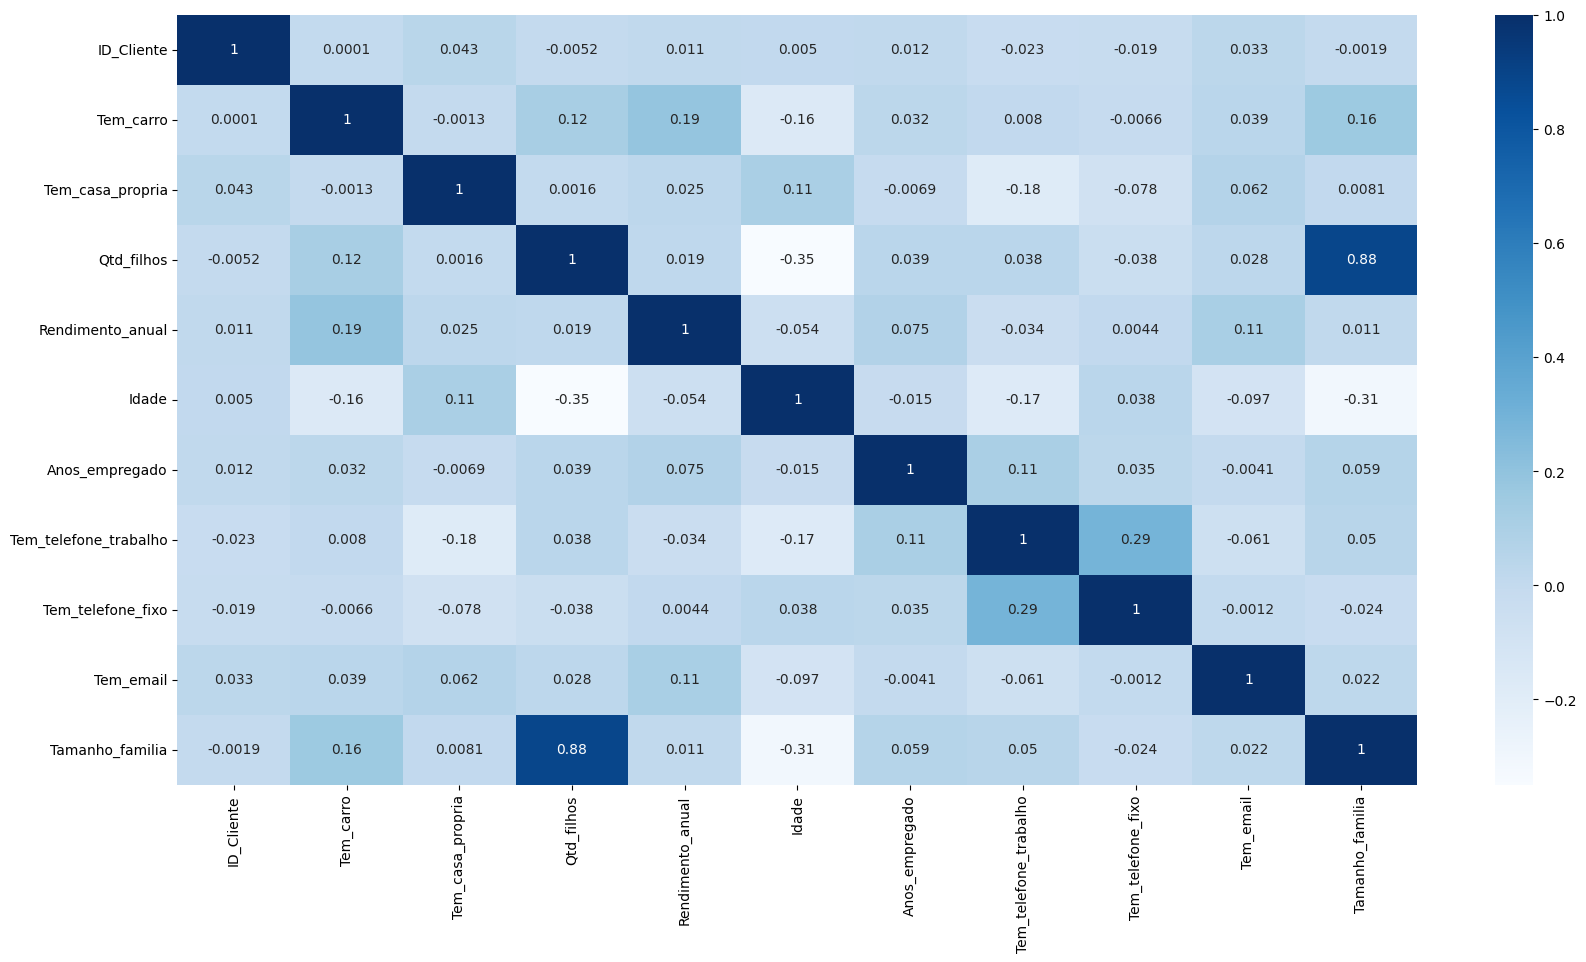

In [13]:
# analisando as correlacoes
numeric_df = df_cadastro.select_dtypes(include=['number'])
corr = numeric_df.corr()

fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.heatmap(corr, cmap='Blues', annot=True)

In [14]:
# removendo colunas
df_cadastro.drop(columns=['Qtd_filhos'], inplace=True)

In [15]:
# reeordenando as colunas
df_cadastro = df_cadastro[['ID_Cliente', 'Tem_carro', 'Tem_casa_propria', 'Tem_telefone_trabalho', 'Tem_telefone_fixo', 'Tem_email',
                           'Tamanho_familia', 'Rendimento_anual', 'Idade', 'Anos_empregado', 'Categoria_de_renda', 'Grau_escolaridade', 'Estado_civil', 'Moradia', 'Ocupacao']]

<Axes: xlabel='Categoria_de_renda'>

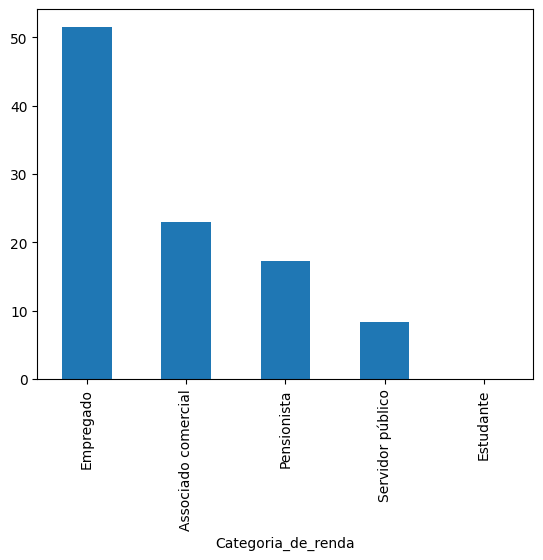

In [16]:
(df_cadastro.Categoria_de_renda.value_counts(normalize=True)*100).plot(kind='bar', )

In [17]:
colunas_quantitativas = ['Tamanho_familia', 'Rendimento_anual', 'Idade', 'Anos_empregado']
df_cadastro[colunas_quantitativas].describe()

,Tamanho_familia,Rendimento_anual,Idade,Anos_empregado
count,438463.000000,4.384630e+05,438463.000000,438463.000000
mean,2.194461,1.875220e+05,43.800857,5.948371
std,0.897194,1.100832e+05,11.458262,6.564112
min,1.000000,2.610000e+04,20.504186,0.000000
25%,2.000000,1.215000e+05,34.262168,1.015763
50%,2.000000,1.611000e+05,42.793487,4.019247
75%,3.000000,2.250000e+05,53.345380,8.495725
max,20.000000,6.750000e+06,68.997994,47.998248


In [18]:
df_cadastro['Categoria_de_renda'].value_counts(normalize = True) * 100

Categoria_de_renda
Empregado              51.557144
Associado comercial    22.972520
Pensionista            17.214223
Servidor público        8.252236
Estudante               0.003877
Name: proportion, dtype: float64

In [19]:
df_cadastro['Grau_escolaridade'].value_counts(normalize = True) * 100

Grau_escolaridade
Ensino médio                  68.821314
Ensino superior               26.797928
Ensino superior incompleto     3.385690
Ensino fundamental             0.923909
Pós-graduação                  0.071158
Name: proportion, dtype: float64

In [20]:
df_cadastro['Estado_civil'].value_counts(normalize = True) * 100

Estado_civil
Casado           68.367912
Solteiro         12.601976
União-estável     8.329323
Divorciado        6.214663
Viúvo             4.486125
Name: proportion, dtype: float64

In [21]:
df_cadastro['Moradia'].value_counts(normalize = True) * 100

Moradia
Casa/apartamento próprio    89.801876
Mora com os pais             4.349740
Habitação pública            3.241094
Apartamento alugado          1.362259
Apartamento comercial        0.894032
Cooperativa habitacional     0.350999
Name: proportion, dtype: float64

In [22]:
df_cadastro['Ocupacao'].value_counts(normalize = True) * 100

Ocupacao
Outros                  30.601670
Construção Civil        17.840730
Equipe principal         9.805388
Vendas                   9.371828
Gerência                 8.091219
Motorista                5.949191
Alta tecnologia          3.941724
Contabilidade            3.644549
Medicina                 3.083042
Cozinha                  1.841432
Segurança                1.822959
Limpeza                  1.332610
Serviço privado          0.787980
Baixa qualificação       0.488069
Secretariado             0.466174
Garçom                   0.379736
Corretor imobiliário     0.237420
RH                       0.176526
TI                       0.137754
Name: proportion, dtype: float64

In [23]:
#Configurações dos gráficos:
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (10,6)

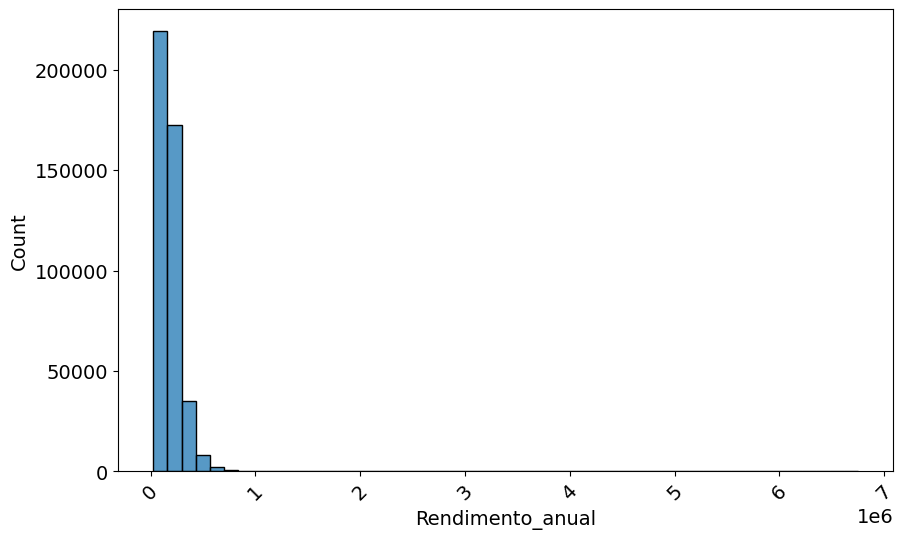

In [24]:
sns.histplot(data=df_cadastro, x='Rendimento_anual', bins=50) 
plt.xticks(rotation=45)
plt.show()

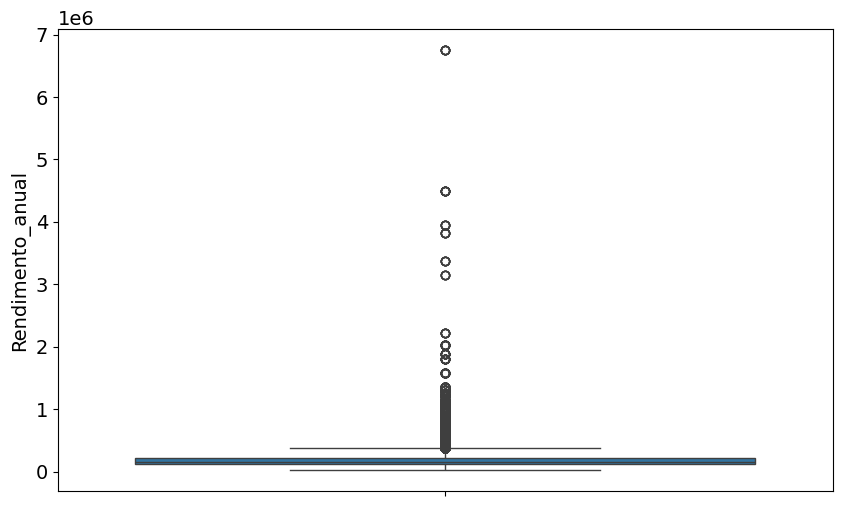

In [25]:
sns.boxplot(data=df_cadastro, y='Rendimento_anual') 
plt.xticks(rotation=45)
plt.show()

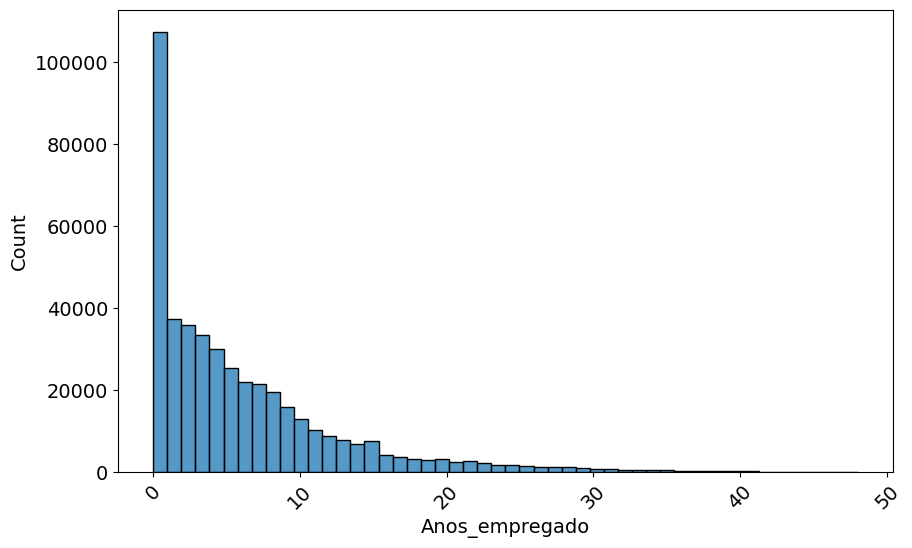

In [26]:
sns.histplot(data=df_cadastro, x='Anos_empregado', bins=50) 
plt.xticks(rotation=45)
plt.show()

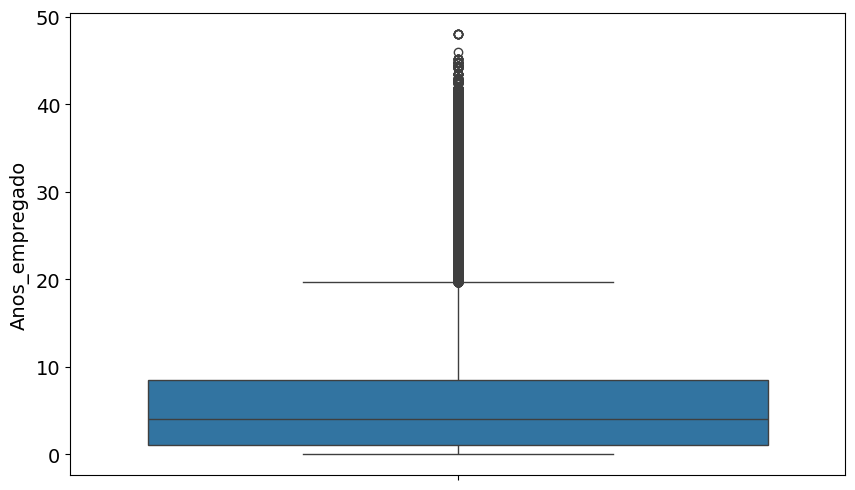

In [27]:
sns.boxplot(data=df_cadastro, y='Anos_empregado') 
plt.xticks(rotation=45)
plt.show()

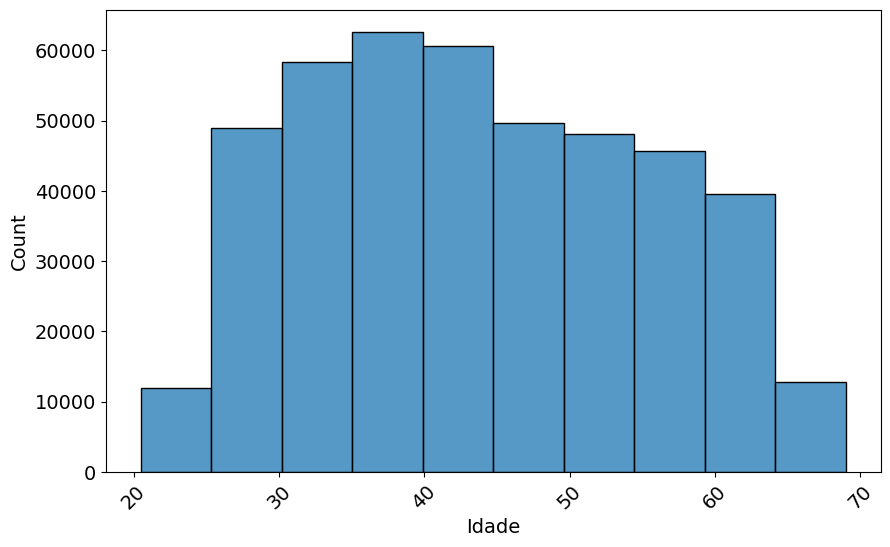

In [28]:
sns.histplot(data=df_cadastro, x='Idade', bins=10) 
plt.xticks(rotation=45)
plt.show()

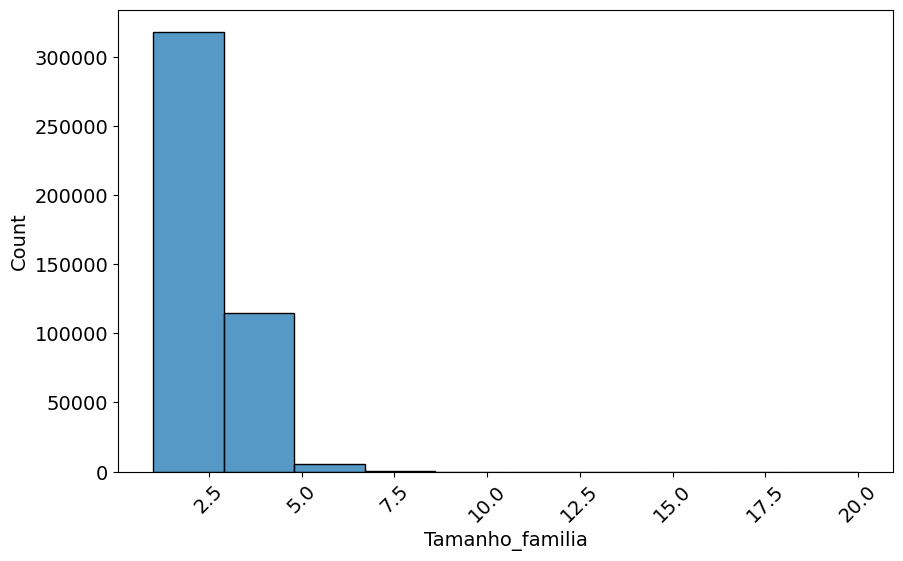

In [29]:
sns.histplot(data=df_cadastro, x='Tamanho_familia', bins=10) 
plt.xticks(rotation=45)
plt.show()

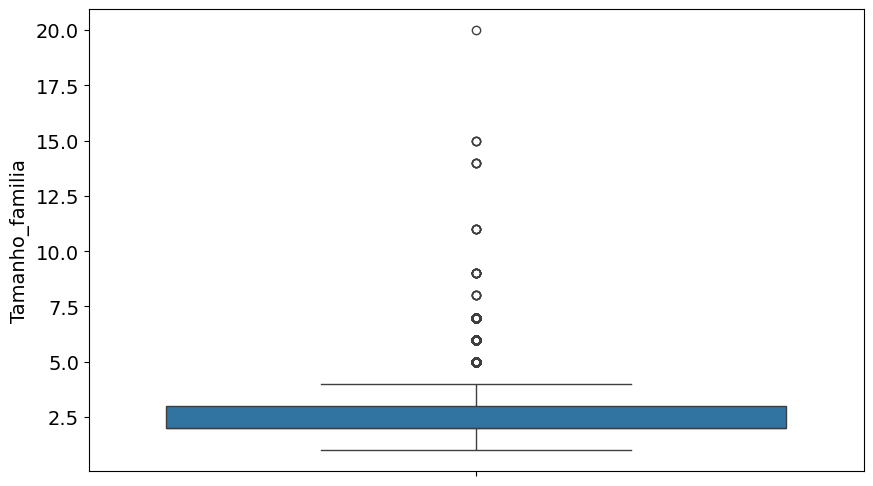

In [30]:
sns.boxplot(data=df_cadastro, y='Tamanho_familia') 
plt.xticks(rotation=45)
plt.show()

In [31]:
'''Técnica para remoção de outliers a partir de um intervalo de confiança
o valor +- o desvio-padrão'''

coluna = df_cadastro['Rendimento_anual']

coluna_med = coluna.mean()
coluna_std = coluna.std()

limite_sup = coluna_med + (2 * coluna_std)
limite_inf = coluna_med - (2 * coluna_std)

index_outliers = []

for index, valor in coluna.items(): 
  if valor > limite_sup or valor < limite_inf:
    index_outliers.append(index)

len(index_outliers)

12641

In [32]:
df_cadastro = df_cadastro.drop(index_outliers)
df_cadastro.shape

(425822, 15)

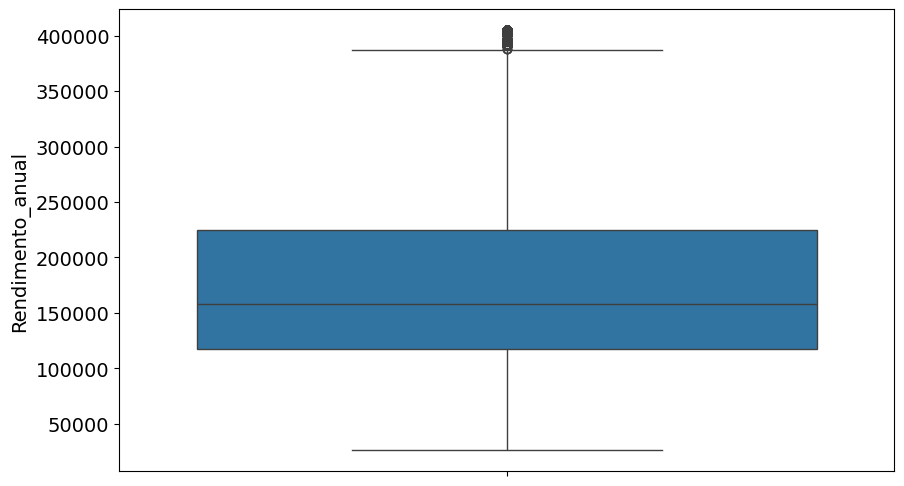

In [33]:
sns.boxplot(data=df_cadastro, y='Rendimento_anual') 
plt.xticks(rotation=45)
plt.show()

In [34]:
df_cadastro['Rendimento_anual'].max

<bound method Series.max of 2         112500.0
3         270000.0
4         270000.0
5         270000.0
6         270000.0
            ...   
438552    135000.0
438553    103500.0
438554     54000.0
438555     72000.0
438556    121500.0
Name: Rendimento_anual, Length: 425822, dtype: float64>

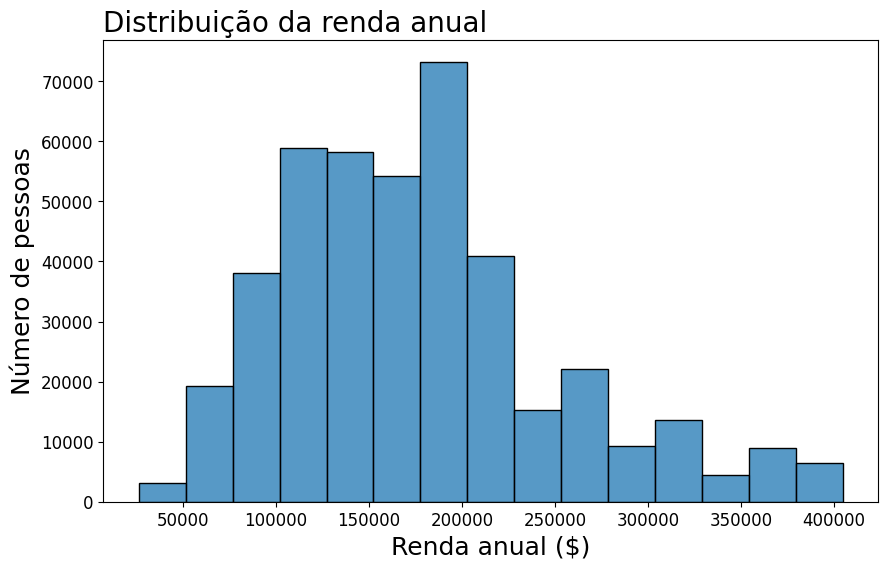

In [35]:
fig = plt.figure(figsize=(10,6))
ax = sns.histplot(data=df_cadastro, x='Rendimento_anual', bins=15)
plt.xticks(rotation=360)
ax.set_title('Distribuição da renda anual', fontsize = 20, loc='left')
ax.set_ylabel('Número de pessoas', fontsize = 18)
ax.set_xlabel('Renda anual ($)', fontsize = 18)
ax.yaxis.set_tick_params(labelsize=12)
ax.xaxis.set_tick_params(labelsize=12)
plt.show()

### Dataset Historico Aprovados

In [36]:
# carregando base de aprovados
aprovados = pd.read_csv('https://github.com/alura-tech/alura-tech-pos-data-science-credit-scoring-streamlit/blob/main/dados/clientes_aprovados.csv?raw=True')  

KeyboardInterrupt: 

In [114]:
# verificando as informacoes
aprovados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID_Cliente      1048575 non-null  int64 
 1   Mes_referencia  1048575 non-null  int64 
 2   Faixa_atraso    1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [115]:
aprovados.head(3)

,ID_Cliente,Mes_referencia,Faixa_atraso
0,5001711,0,nenhum empréstimo
1,5001711,-1,1-29 dias
2,5001711,-2,1-29 dias


In [116]:
aprovados.query('ID_Cliente == 5001712')

,ID_Cliente,Mes_referencia,Faixa_atraso
4,5001712,0,pagamento realizado
5,5001712,-1,pagamento realizado
6,5001712,-2,pagamento realizado
7,5001712,-3,pagamento realizado
8,5001712,-4,pagamento realizado
9,5001712,-5,pagamento realizado
10,5001712,-6,pagamento realizado
11,5001712,-7,pagamento realizado
12,5001712,-8,pagamento realizado
13,5001712,-9,1-29 dias


#### Criando a variável Target

In [117]:
# criando df com ref de cadastro e ref mais recente
mes_ref = aprovados.groupby('ID_Cliente').agg(Abertura=('Mes_referencia', 'min'), Final=('Mes_referencia', 'max')).reset_index()

# acrescentando informacoes de refs
df_aprovados = pd.merge(
                    aprovados,
                    mes_ref,
                    on='ID_Cliente',
                    how='inner'
                )

# dicionario com id de faixa de atraso
dict_faixa_atraso_id = {'nenhum empréstimo':0, 'pagamento realizado':1, '1-29 dias':2,
                        '30-59 dias':3, '60-89 dias':4, '90-119 dias':5, '120-149 dias':6,
                        '>150 dias':7
                        }

# tratamento de colunas
df_aprovados = df_aprovados.assign(
                                    Janela=df_aprovados['Final'] - df_aprovados['Abertura'],
                                    MOB = df_aprovados['Mes_referencia'] - df_aprovados['Abertura'],
                                    id_faixa_atraso = df_aprovados['Faixa_atraso'].map(dict_faixa_atraso_id),
                                    mau_pagador=lambda x: x['id_faixa_atraso'].apply(lambda x: 1 if x > 3 else 0)
                                )

In [118]:
# o df tem mais de um vou filtrar apenas informaçoes de refs importantes
df_registros_creditos_ID = df_aprovados[['ID_Cliente','Abertura', 'Final', 'Janela']].groupby('ID_Cliente').apply(lambda x: x.iloc[0]).reset_index(drop=True)
df_registros_creditos_ID

,ID_Cliente,Abertura,Final,Janela
0,5001711,-3,0,3
1,5001712,-18,0,18
2,5001713,-21,0,21
3,5001714,-14,0,14
4,5001715,-59,0,59
...,...,...,...,...
45980,5150482,-28,-11,17
45981,5150483,-17,0,17
45982,5150484,-12,0,12
45983,5150485,-1,0,1


In [119]:
# Quantida de clientes por tempo de cadastro
df_denominador = df_registros_creditos_ID.groupby('Abertura').apply(lambda x: x['ID_Cliente'].count()).reset_index(name='Qtd_Clientes')
df_denominador

,Abertura,Qtd_Clientes
0,-60,415
1,-59,406
2,-58,440
3,-57,400
4,-56,470
...,...,...
56,-4,874
57,-3,919
58,-2,771
59,-1,686


In [120]:
# quantidade de clientes por abertura e MOB
df_vintage = df_aprovados.groupby(['Abertura', 'MOB']).apply(lambda x: x['ID_Cliente'].count()).reset_index(name='Qtd_Clientes')
df_vintage = pd.merge(df_vintage[['Abertura', 'MOB']],
                      df_denominador,
                      on='Abertura',
                      how='left')
df_vintage

,Abertura,MOB,Qtd_Clientes
0,-60,0,415
1,-60,1,415
2,-60,2,415
3,-60,3,415
4,-60,4,415
...,...,...,...
1886,-2,1,771
1887,-2,2,771
1888,-1,0,686
1889,-1,1,686


In [121]:
# verificando quantidade de maus pagadores por tempo de abertura e MOB
df_denominador['Qtd_Mau'] = np.nan

for j in range(-60, 1):
    ls = []
    for i in range(0,61):
        due = list(df_aprovados.query('mau_pagador == 1 and MOB ==@i and Abertura ==@j')['ID_Cliente'])
        ls.extend(due)
        df_vintage.loc[(df_vintage['MOB'] == i) & (df_vintage['Abertura'] == j), 'Qtd_Mau'] = len(set(ls))

df_vintage['Taxa_de_Mau'] = df_vintage['Qtd_Mau'] / df_vintage['Qtd_Clientes']


df_vintage.head()

,Abertura,MOB,Qtd_Clientes,Qtd_Mau,Taxa_de_Mau
0,-60,0,415,0.0,0.0
1,-60,1,415,0.0,0.0
2,-60,2,415,0.0,0.0
3,-60,3,415,0.0,0.0
4,-60,4,415,0.0,0.0


In [122]:
df_vintage_pivot = df_vintage.pivot(
                                    index='Abertura',
                                    columns='MOB',
                                    values='Taxa_de_Mau'
                                    )
df_vintage_pivot

MOB,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
Abertura,,,,,,,,,,,,,,,,,,,,,
-60,0.0,0.0,0.000000,0.000000,0.000000,0.002410,0.002410,0.007229,0.007229,0.009639,...,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.031325,0.031325,0.031325
-59,0.0,0.0,0.000000,0.004926,0.004926,0.004926,0.007389,0.007389,0.007389,0.012315,...,0.029557,0.029557,0.029557,0.032020,0.032020,0.032020,0.032020,0.032020,0.032020,NaN
-58,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.004545,0.006818,0.006818,...,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN
-57,0.0,0.0,0.000000,0.000000,0.002500,0.002500,0.002500,0.007500,0.007500,0.007500,...,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN,NaN
-56,0.0,0.0,0.004255,0.004255,0.008511,0.010638,0.010638,0.017021,0.017021,0.021277,...,0.036170,0.036170,0.036170,0.036170,0.038298,0.038298,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-4,0.0,0.0,0.000000,0.003432,0.003432,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-3,0.0,0.0,0.001088,0.001088,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-2,0.0,0.0,0.001297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


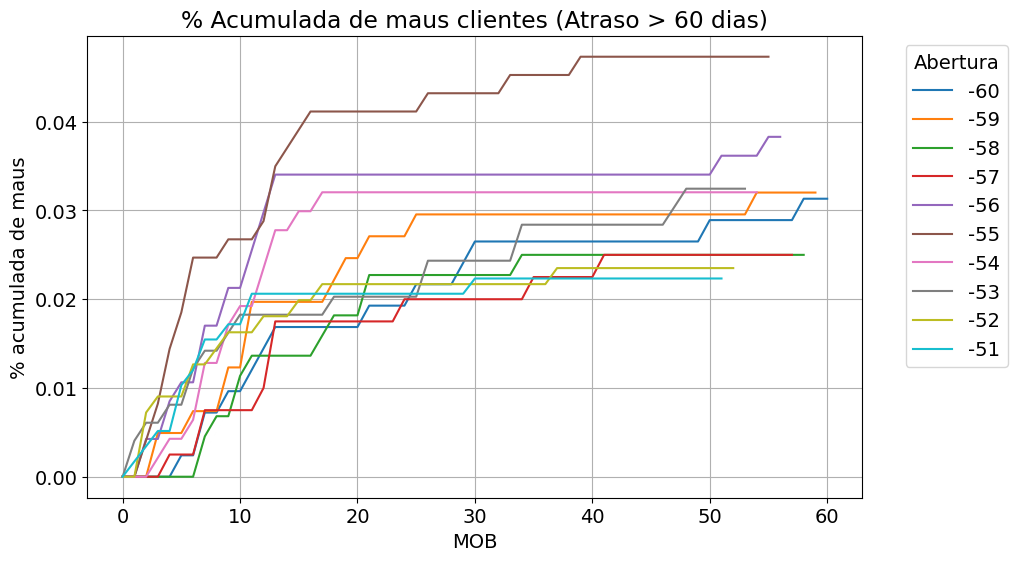

In [123]:
lst = [i for i in range(0,61)]
df_vintage_pivot[lst].T.iloc[:, :10].plot(
                                        legend=True,
                                        grid=True,
                                        title='% Acumulada de maus clientes (Atraso > 60 dias)'
                                    )

plt.xlabel('MOB')
plt.ylabel('% acumulada de maus')
plt.legend(bbox_to_anchor=(1.2, 1), title='Abertura')
plt.show()

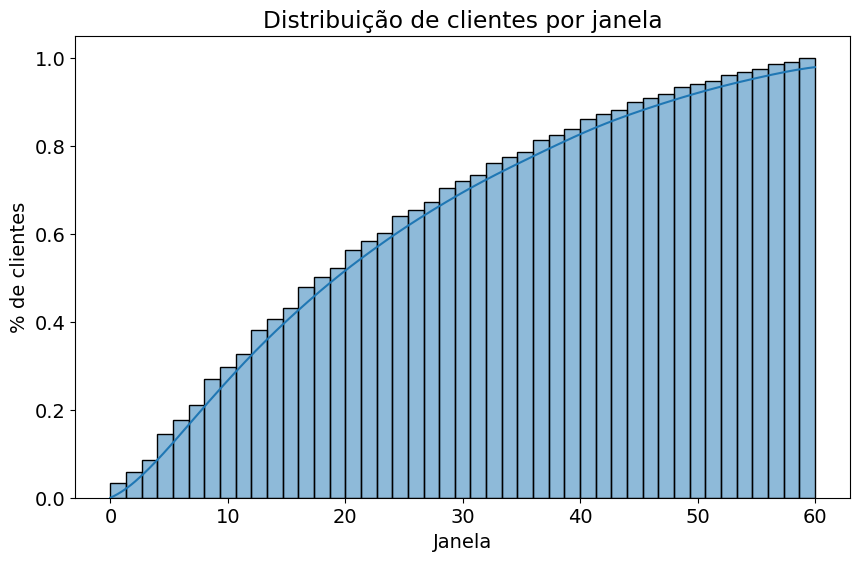

In [124]:
sns.histplot(data=df_registros_creditos_ID, x='Janela', cumulative=True, stat='density', kde=True)
plt.title('Distribuição de clientes por janela')
plt.xlabel('Janela')
plt.ylabel('% de clientes')
plt.show()

In [125]:
dict_intervalo_atraso = {'maior_30_dias':3, 'maior_60_dias':4, 'maior_90_dias':5,
                         'maior_120_dias':6, 'maior_150_dias':7}

In [126]:
for chave, valor in dict_intervalo_atraso.items():
    df_aprovados[f'Mau_{chave}'] = df_aprovados.apply(lambda x: 1 if x['id_faixa_atraso'] >= valor else 0, axis=1)

In [127]:
df_aprovados.head()

,ID_Cliente,Mes_referencia,Faixa_atraso,Abertura,Final,Janela,MOB,id_faixa_atraso,mau_pagador,Mau_maior_30_dias,Mau_maior_60_dias,Mau_maior_90_dias,Mau_maior_120_dias,Mau_maior_150_dias
0,5001711,0,nenhum empréstimo,-3,0,3,3,0,0,0,0,0,0,0
1,5001711,-1,1-29 dias,-3,0,3,2,2,0,0,0,0,0,0
2,5001711,-2,1-29 dias,-3,0,3,1,2,0,0,0,0,0,0
3,5001711,-3,1-29 dias,-3,0,3,0,2,0,0,0,0,0,0
4,5001712,0,pagamento realizado,-18,0,18,18,1,0,0,0,0,0,0


In [128]:
dict_taxa_mau = {}
id_sum = len(set(df_aprovados['ID_Cliente']))

for chave in dict_intervalo_atraso.keys():
  df_min_mau = df_aprovados.query(f'Mau_{chave} == 1').groupby('ID_Cliente')['MOB'].min().reset_index()
  df_mob_taxa_mau = pd.DataFrame({'MOB':range(0,61), 'Taxa_Mau': np.nan})
  lst = []
  for i in range(0,61):
      due = df_min_mau.query('MOB == @i')['ID_Cliente'].to_list()
      lst.extend(due) #cumsum
      df_mob_taxa_mau.loc[df_mob_taxa_mau['MOB'] == i, 'Taxa_Mau'] = len(set(lst)) / id_sum
  dict_taxa_mau[chave] = df_mob_taxa_mau['Taxa_Mau']

df_taxa_mau = pd.DataFrame(dict_taxa_mau)
df_taxa_mau

,maior_30_dias,maior_60_dias,maior_90_dias,maior_120_dias,maior_150_dias
0,0.000304,0.000022,0.000022,0.000022,0.000022
1,0.011612,0.000174,0.000087,0.000087,0.000087
2,0.025878,0.001153,0.000196,0.000174,0.000174
3,0.036860,0.002240,0.000696,0.000304,0.000304
4,0.047385,0.003392,0.001044,0.000696,0.000348
...,...,...,...,...,...
56,0.116321,0.014483,0.007176,0.005263,0.004219
57,0.116321,0.014483,0.007176,0.005263,0.004219
58,0.116321,0.014505,0.007198,0.005284,0.004241
59,0.116321,0.014505,0.007198,0.005284,0.004241


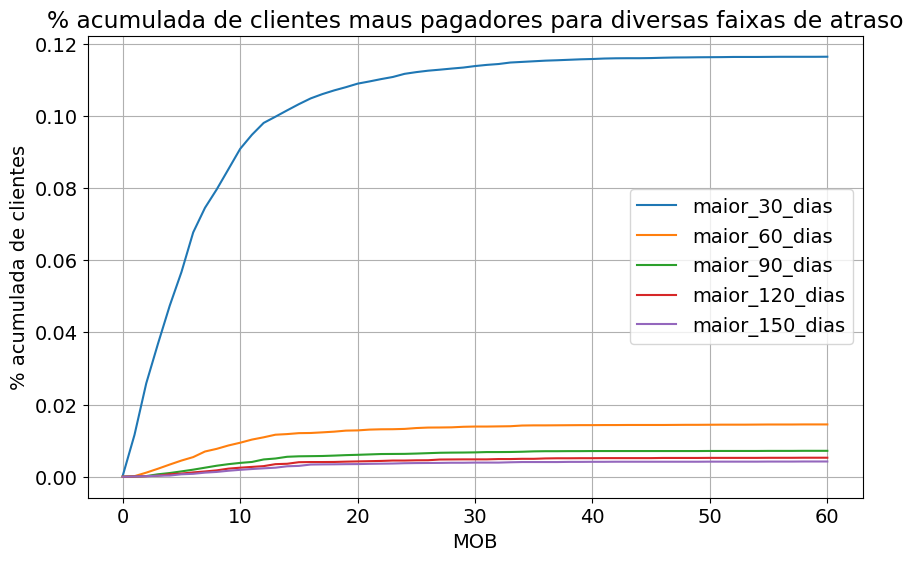

In [129]:
df_taxa_mau.plot(grid=True, title='% acumulada de clientes maus pagadores para diversas faixas de atraso', figsize=(10,6))
plt.xlabel('MOB')
plt.ylabel('% acumulada de clientes')
plt.show()

In [130]:
len(df_aprovados.query('Janela >= 12').groupby('ID_Cliente').count().index)

30918

In [131]:
df_clientes_aprovados_tratamento = df_aprovados.query('Janela >=12')
df_clientes_aprovados_tratamento.shape

(943061, 14)

In [132]:
df_clientes_aprovados_tratamento['Faixa_atraso'].unique()

array(['pagamento realizado', '1-29 dias', 'nenhum empréstimo',
       '30-59 dias', '60-89 dias', '90-119 dias', '120-149 dias',
       '>150 dias'], dtype=object)

In [133]:
def verifica(registros):
    lista_status = registros['Faixa_atraso'].to_list()
    if '60-89 dias' in lista_status or '90-119 dias' in lista_status or '120-149 dias' in lista_status or '>150 dias' in lista_status:
        return 1
    else:
        return 0
    
df_registro_creditos_id = pd.DataFrame(df_clientes_aprovados_tratamento.groupby('ID_Cliente').apply(verifica)).reset_index()

df_registro_creditos_id.columns = ['ID_Cliente', 'Mau'] 

In [134]:
df_registro_creditos_id

,ID_Cliente,Mau
0,5001712,0
1,5001713,0
2,5001714,0
3,5001715,0
4,5001717,0
...,...,...
30913,5150481,0
30914,5150482,0
30915,5150483,0
30916,5150484,0


In [135]:
df_registros_clientes_targets = df_cadastro.merge(df_registro_creditos_id, on='ID_Cliente')
df_registros_clientes_targets.head()

,ID_Cliente,Tem_carro,Tem_casa_propria,Tem_telefone_trabalho,Tem_telefone_fixo,Tem_email,Tamanho_familia,Rendimento_anual,Idade,Anos_empregado,Categoria_de_renda,Grau_escolaridade,Estado_civil,Moradia,Ocupacao,Mau
0,5008806,1,1,0,0,0,2.0,112500.0,58.793815,3.104787,Empregado,Ensino médio,Casado,Casa/apartamento próprio,Segurança,0
1,5008810,0,1,0,1,1,1.0,270000.0,52.321403,8.353354,Associado comercial,Ensino médio,Solteiro,Casa/apartamento próprio,Vendas,0
2,5008811,0,1,0,1,1,1.0,270000.0,52.321403,8.353354,Associado comercial,Ensino médio,Solteiro,Casa/apartamento próprio,Vendas,0
3,5008812,0,1,0,0,0,1.0,283500.0,61.504343,0.000000,Pensionista,Ensino superior,Divorciado,Casa/apartamento próprio,Outros,0
4,5008813,0,1,0,0,0,1.0,283500.0,61.504343,0.000000,Pensionista,Ensino superior,Divorciado,Casa/apartamento próprio,Outros,0


In [136]:
df_registros_clientes_targets['Mau'].value_counts(normalize=True)*100

Mau
0    97.726673
1     2.273327
Name: proportion, dtype: float64

In [137]:
SEED = 1561651

In [138]:
train_df, test_df = train_test_split(df_registros_clientes_targets, test_size=0.2, random_state=SEED)

In [139]:
train_df.shape

(18193, 16)

In [140]:
test_df.shape

(4549, 16)

In [141]:
df_registros_clientes_targets.to_csv('df_clean.csv', index=False)

### Pipeline

In [142]:
class DropFeatures(BaseEstimator,TransformerMixin):
    def __init__(self,feature_to_drop = ['ID_Cliente']):
        self.feature_to_drop = feature_to_drop
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feature_to_drop).issubset(df.columns)):
            df.drop(self.feature_to_drop,axis=1,inplace=True)
            return df
        else:
            print('Uma ou mais features não estão no DataFrame1')
            return df

In [143]:
class MinMax(BaseEstimator,TransformerMixin):
    def __init__(self,min_max_scaler  = ['Idade', 'Rendimento_anual', 'Tamanho_familia', 'Anos_empregado']):
        self.min_max_scaler = min_max_scaler 
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.min_max_scaler ).issubset(df.columns)):
            min_max_enc = MinMaxScaler()
            df[self.min_max_scaler] = min_max_enc.fit_transform(df[self.min_max_scaler ])
            return df
        else:
            print('Uma ou mais features não estão no DataFrame2')
            return df

In [144]:
class OneHotEncodingNames(BaseEstimator,TransformerMixin):
    def __init__(self,OneHotEncoding = ['Estado_civil', 'Moradia', 'Categoria_de_renda', 
                                        'Ocupacao']):                                      
                                                                               
        self.OneHotEncoding = OneHotEncoding

    def fit(self,df):
        return self

    def transform(self,df):
        if (set(self.OneHotEncoding).issubset(df.columns)):
            # função para one-hot-encoding das features
            def one_hot_enc(df,OneHotEncoding):
                one_hot_enc = OneHotEncoder()
                one_hot_enc.fit(df[OneHotEncoding])
                # obtendo o resultado dos nomes das colunas
                feature_names = one_hot_enc.get_feature_names_out(OneHotEncoding)
                # mudando o array do one hot encoding para um dataframe com os nomes das colunas
                df = pd.DataFrame(one_hot_enc.transform(df[self.OneHotEncoding]).toarray(),
                                  columns= feature_names,index=df.index)
                return df

            # função para concatenar as features com aquelas que não passaram pelo one-hot-encoding
            def concat_with_rest(df,one_hot_enc_df,OneHotEncoding):              
                # get the rest of the features
                outras_features = [feature for feature in df.columns if feature not in OneHotEncoding]
                # concaternar o restante das features com as features que passaram pelo one-hot-encoding
                df_concat = pd.concat([one_hot_enc_df, df[outras_features]],axis=1)
                return df_concat

            # one hot encoded dataframe
            df_OneHotEncoding = one_hot_enc(df,self.OneHotEncoding)

            # retorna o dataframe concatenado
            df_full = concat_with_rest(df, df_OneHotEncoding,self.OneHotEncoding)
            return df_full

        else:
            print('Uma ou mais features não estão no DataFrame3')
            return df


In [145]:
class OrdinalFeature(BaseEstimator,TransformerMixin):
    def __init__(self,ordinal_feature = ['Grau_escolaridade']):
        self.ordinal_feature = ordinal_feature
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Grau_escolaridade' in df.columns:
            ordinal_encoder = OrdinalEncoder()
            df[self.ordinal_feature] = ordinal_encoder.fit_transform(df[self.ordinal_feature])
            return df
        else:
            print("Grau_escolaridade não está no DataFrame4")
            return df

In [146]:
class Oversample(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Mau' in df.columns:
            # função smote para superamostrar a classe minoritária para corrigir os dados desbalanceados
            oversample = SMOTE(sampling_strategy='minority')
            X_bal, y_bal = oversample.fit_resample(df.loc[:, df.columns != 'Mau'], df['Mau'])
            df_bal = pd.concat([pd.DataFrame(X_bal),pd.DataFrame(y_bal)],axis=1)
            return df_bal
        else:
            print("O target não está no DataFrame5")
            return df

In [147]:
def pipeline(df):

    pipeline = Pipeline([
        ('feature_dropper', DropFeatures()),
        ('OneHotEncoding', OneHotEncodingNames()),
        ('ordinal_feature', OrdinalFeature()),
        ('min_max_scaler', MinMax()),
        ('oversample', Oversample())
    ])
    df_pipeline = pipeline.fit_transform(df)
    return df_pipeline


### Criando Modelos de ML

In [148]:
treino = pipeline(train_df)
X_treino, y_treino = treino.loc[:, treino.columns != 'Mau'], treino['Mau']

In [149]:
teste = pipeline(test_df)
X_test, y_test = teste.loc[:, teste.columns != 'Mau'], teste['Mau']

In [150]:
def roda_modelo(modelo):
    modelo.fit(X_treino, y_treino)

    prob_predict = modelo.predict_proba(X_test)

    print(f'\n-----------------------Resultados {modelo}-----------------------\n')

    data_bom = np.sort(prob_predict[:, 0])
    data_mau = np.sort(prob_predict[:, 1])
    kteste = stats.ks_2samp(data_bom, data_mau)

    print(f'Métrica KS: {kteste}')

    print(f'\n Confusion Matrix\n')

    fig, ax = plt.subplots(figsize=(7,7))
    matriz_confusao = ConfusionMatrixDisplay.from_estimator(
                                        modelo, X_test, y_test, normalize='true',
                                        display_labels=['Bom-pagador', 'Mau-pagador'],
                                        cmap=plt.cm.Blues, ax=ax)
    ax.set_title('Matriz de Confusão\nNormalizada', fontsize=16, fontweight='bold')
    ax.set_xlabel('Label predita', fontsize=14)
    ax.set_ylabel('Label verdadeira', fontsize=14)
    plt.grid(False)
    plt.show()

    predicao = modelo.predict(X_test)
    print('\nClassification Report\n')
    print(classification_report(y_test, predicao, zero_division=0))

    print("\nRoc Curve\n")
    fpr, tpr, _ = roc_curve(y_test, prob_predict[:, 1])
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    plt.show()


-----------------------Resultados LogisticRegression()-----------------------

Métrica KS: KstestResult(statistic=0.04446440601841455, pvalue=4.4866484782128156e-08, statistic_location=0.7369185308633228, statistic_sign=-1)

 Confusion Matrix



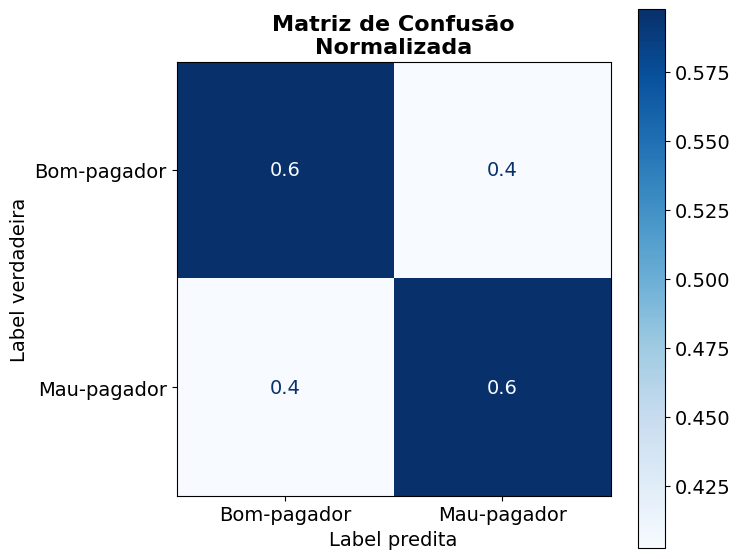

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Classification Report

              precision    recall  f1-score   support

           0       0.60      0.60      0.60      4453
           1       0.60      0.60      0.60      4453

    accuracy                           0.60      8906
   macro avg       0.60      0.60      0.60      8906
weighted avg       0.60      0.60      0.60      8906


Roc Curve



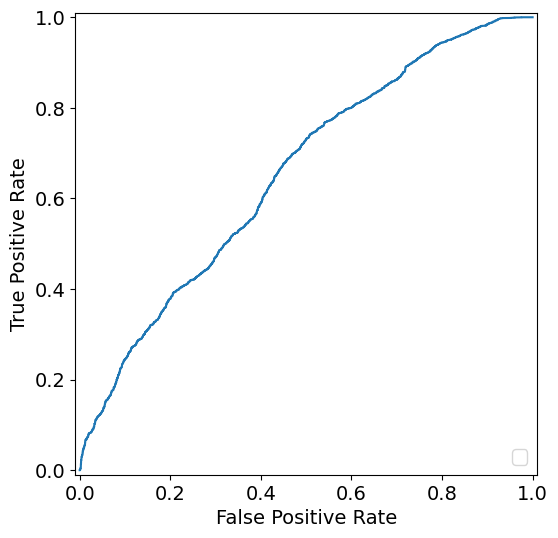

In [154]:
modelo_logistico = LogisticRegression()
roda_modelo(modelo_logistico)


-----------------------Resultados DecisionTreeClassifier()-----------------------

Métrica KS: KstestResult(statistic=0.2195149337525264, pvalue=2.5532491157984368e-188, statistic_location=0.6190476190476191, statistic_sign=-1)

 Confusion Matrix



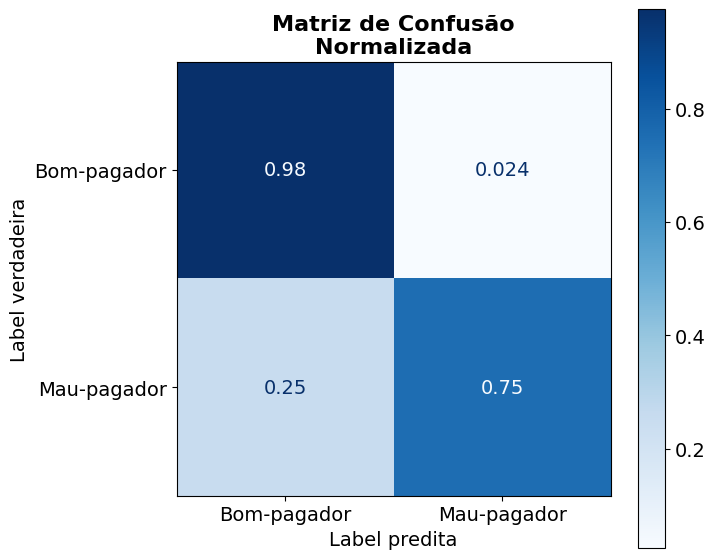

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Classification Report

              precision    recall  f1-score   support

           0       0.80      0.98      0.88      4453
           1       0.97      0.75      0.85      4453

    accuracy                           0.86      8906
   macro avg       0.88      0.86      0.86      8906
weighted avg       0.88      0.86      0.86      8906


Roc Curve



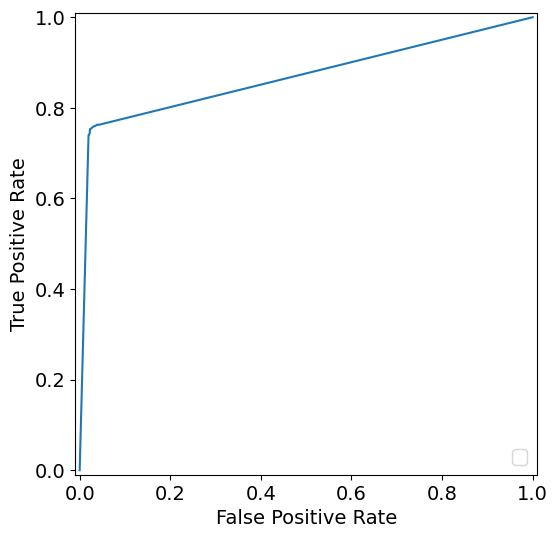

In [155]:
modelo_tree = DecisionTreeClassifier()
roda_modelo(modelo_tree)


-----------------------Resultados RandomForestClassifier()-----------------------

Métrica KS: KstestResult(statistic=0.38670559173590835, pvalue=0.0, statistic_location=0.87, statistic_sign=-1)

 Confusion Matrix



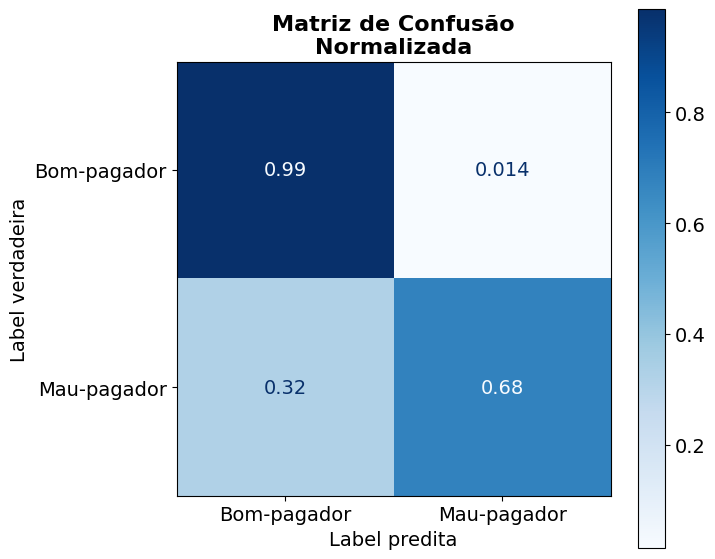

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Classification Report

              precision    recall  f1-score   support

           0       0.75      0.99      0.85      4453
           1       0.98      0.68      0.80      4453

    accuracy                           0.83      8906
   macro avg       0.87      0.83      0.83      8906
weighted avg       0.87      0.83      0.83      8906


Roc Curve



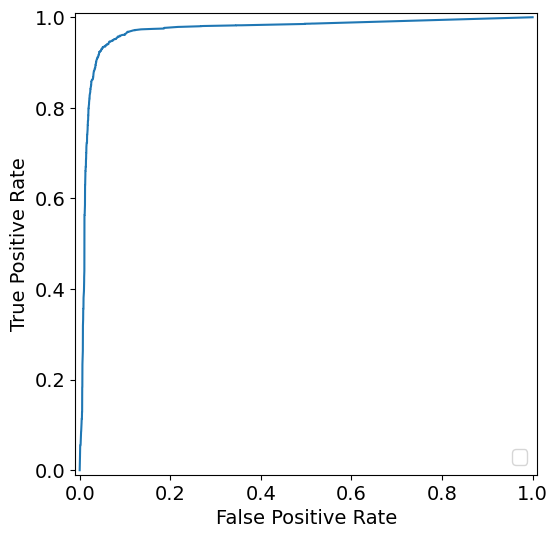

In [156]:
modelo_rf = RandomForestClassifier()
roda_modelo(modelo_rf)


-----------------------Resultados GradientBoostingClassifier()-----------------------

Métrica KS: KstestResult(statistic=0.13833370761284527, pvalue=1.126615426497424e-74, statistic_location=0.157536204359773, statistic_sign=1)

 Confusion Matrix



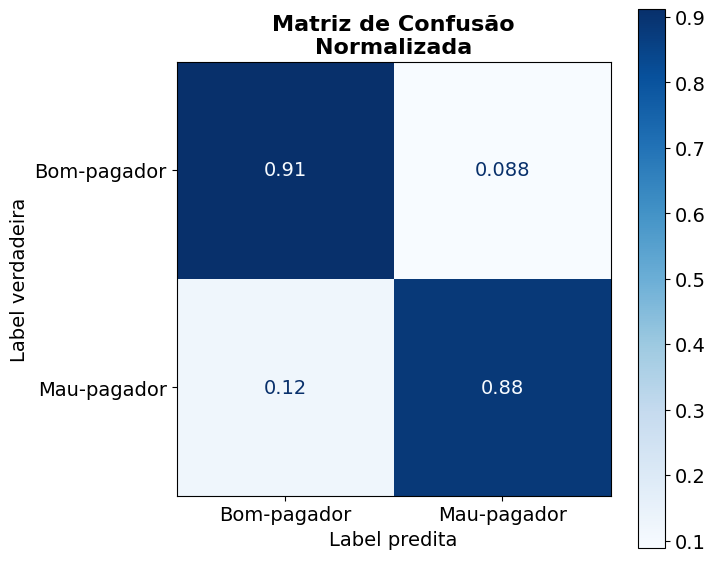


Classification Report

              precision    recall  f1-score   support

           0       0.88      0.91      0.90      4453
           1       0.91      0.88      0.89      4453

    accuracy                           0.90      8906
   macro avg       0.90      0.90      0.90      8906
weighted avg       0.90      0.90      0.90      8906


Roc Curve



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


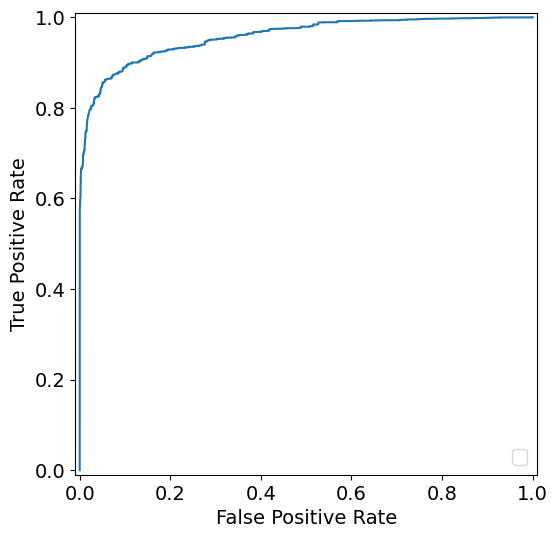

In [157]:
modelo_xgb = GradientBoostingClassifier()
roda_modelo(modelo_xgb)

In [158]:
# joblib.dump(modelo_xgb, r'D:\Documentos\FIAP - Pos Tech Data Analytics\Aulas\Fase 4\credit_score_07-10-2024\modelo\xgb.joblib')